In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from backtest_algo import backtester
import matplotlib.pyplot as plt
import openpyxl

Instantiate the backtester and add the data that you want to work on

In [2]:
engine = backtester()

start = "2020-01-01"
end = "2023-01-01"


data1 = yf.download("MSFT", start, end)["Adj Close"]
data2 = yf.download("AAPL", start, end)["Adj Close"]
data1 = pd.Series(data1)
data2 = pd.Series(data2)
engine.add_data("MSFT_data",data1)
engine.add_data("AAPL_data",data2)


engine.get_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Data has been appended.
Data has been appended.
Here is your data:
Data set 'MSFT_data':
Date
2019-12-31    151.965714
2020-01-02    154.779510
2020-01-03    152.852234
2020-01-06    153.247314
2020-01-07    151.850067
                 ...    
2022-12-23    236.631805
2022-12-27    234.877365
2022-12-28    232.468719
2022-12-29    238.891769
2022-12-30    237.712219
Name: Adj Close, Length: 757, dtype: float64
Data set 'AAPL_data':
Date
2019-12-31     71.520813
2020-01-02     73.152641
2020-01-03     72.441460
2020-01-06     73.018700
2020-01-07     72.675278
                 ...    
2022-12-23    131.127060
2022-12-27    129.307251
2022-12-28    125.339409
2022-12-29    128.889587
2022-12-30    129.207779
Name: Adj Close, Length: 757, dtype: float64


Plot data

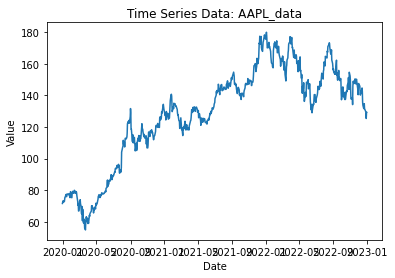

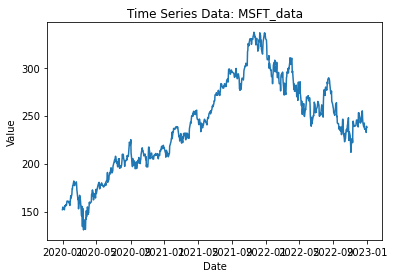

In [3]:
engine.plot_data("AAPL_data")
engine.plot_data("MSFT_data")

Add capital

In [4]:
engine.add_new_capital_size(100000)
print(engine.capital_size)

100000


Now develop a strategy, the engine class takes functions as inputs. This allows you to develop and add multiple strategies with different risk profiles and market dynamics.

For the purpose of this project I simplified the effects of slippage and transactions costs by simply substracting them from the daily gains and daily losses, simulating the effect of not getting the best order execution.

This also assumes that the user has done the statistical or other kinds of analysis to validate the strategy, the input function is simply the rules of making transactions, model training is not a part of this project.

In [5]:
def moving_average_crossover_strategy(data, max_leverage, capital_size):
    short_window = 40
    long_window = 80

    # Calculate moving averages
    short_moving_avg = data.rolling(window=short_window, min_periods=1).mean()
    long_moving_avg = data.rolling(window=long_window, min_periods=1).mean()

    # Identify crossovers
    crossover = short_moving_avg - long_moving_avg

    # Calculate duration of being on one side of the crossover
    duration = crossover.groupby((crossover > 0).diff().ne(0).cumsum()).cumcount() + 1
    duration_factor = duration / duration.max()  # Normalizing factor

    # Generate signals with leverage limit
    signals = pd.Series(0, index=data.index)
    max_position_size = capital_size * max_leverage

    # Calculate scaled positions
    long_positions = (capital_size * duration_factor).clip(upper=max_position_size)
    short_positions = -(capital_size * duration_factor).clip(upper=max_position_size)

    # Apply long and short positions based on crossover
    signals[crossover > 0] = long_positions[crossover > 0]
    signals[crossover < 0] = short_positions[crossover < 0]

    return signals



In [6]:
def momentum_strategy(data, max_leverage, capital_size):
    mean_price = data.mean()
    std_price = data.std()

    # Calculate Z-score (standard score)
    z_score = (data - mean_price) / std_price

    # Generate signals with leverage limit
    signals = pd.Series(index=data.index)
    max_position_size = capital_size * max_leverage

    # Calculate scaled positions
    short_positions = (capital_size * (z_score - 2) / (3 - 2)).clip(upper=max_position_size)
    long_positions = (capital_size * (abs(z_score) - 2) / (3 - 2)).clip(upper=max_position_size)

    # Apply short and long positions based on z_score
    signals[z_score > 2] = -short_positions[z_score > 2]
    signals[z_score < -2] = long_positions[z_score < -2]

    return signals.fillna(0)



Now add the strategies to the backtest engine

In [7]:
engine.add_strategy(moving_average_crossover_strategy)
engine.add_strategy(momentum_strategy)

Strategy has been appended.
Strategy has been appended.


In [8]:
engine.get_strategies() # if you have duplicate strats or data you can use .remove_data or .remove_strategy to remove them by index


Here are your strategies:
<function moving_average_crossover_strategy at 0x000001DF42542050>
<function momentum_strategy at 0x000001DF3CDEE830>


Select the data and strategy for the backtest

In [9]:
engine.select_data("MSFT_data")
engine.select_strategy(0)

engine.selected_data
engine.selected_strategy

<function __main__.moving_average_crossover_strategy(data, max_leverage, capital_size)>

Now you can run a backtest

In [10]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [11]:
engine.run_backtest(start,end,1,0.001,0.001)

Date
2020-01-02    100000.00
2020-01-03    100000.00
2020-01-06    100000.00
2020-01-07    100000.00
2020-01-08    100000.00
                ...    
2022-12-23   2909011.06
2022-12-27   2942483.61
2022-12-28   2989210.61
2022-12-29   2991323.13
2022-12-30   2990546.78
Length: 756, dtype: float64

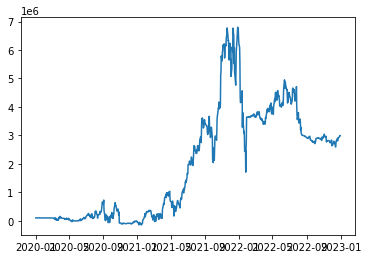

In [12]:
plt.plot(engine.results)

In [13]:
results = engine.results


results_df = results.to_frame(name='Equity')


results_df.to_excel("backtest_results.xlsx", sheet_name='Results')

In [14]:
engine.create_tear_sheet()


Tear Sheet:
Backtest length     : 3.00 years
Total return        : 739194.24%
CAGR                : 1848.08%
Max drawdown        : -50.60%
Volatility          : 44.77%
Sharpe ratio        : 0.03
Skewness            : 10.68
